<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/computer_vision/image_classification/homer_bart_classifiction_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homer/Bart image classification with feature extraction

### Importing the libraries

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import pandas as pd
import numpy as np
import cv2

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import save_model
import math

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'2.15.0'

In [50]:
%run '/content/drive/MyDrive/Workspace/Computer Vision/cv_common.ipynb'

Common library was successfully loaded


### Loading the images

In [51]:
zip_file_path = f'{datasets_directory}/Simpsons/simpsons.zip'
working_directory = './content/simpsons'
data_extract_path = f'{working_directory}/datasets'
train_set_path = f'{data_extract_path}/simpsons/training_set'
test_set_path = f'{data_extract_path}/simpsons/test_set'
model_directory = f'{working_directory}/models'

In [52]:
zip_object = zipfile.ZipFile(file=zip_file_path, mode='r')
zip_object.extractall(data_extract_path)
zip_object.close()

In [53]:
# Create training set generation, in order to provide training image augmentation
# Image augmentation transformations are Rescalling/Rotation/Horizontal Flip/Zoom In or Out
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)

#Loading and transforming image training set
# 1) Resizing all images to 64*64 size
# 2) Shuffling and spliting to baches
train_dataset = training_generator.flow_from_directory(train_set_path,
                                                        target_size = (64, 64),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                       shuffle = True)
train_dataset.classes

Found 196 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [54]:
train_dataset.class_indices

train_dataset

In [55]:
# Create testing set generator.
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(test_set_path,
                                                     target_size = (64, 64),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 73 images belonging to 2 classes.


## Network weight number and layer output size calculation

In [78]:
#Network weights and layer output size calculation with custom code
#Done for the study porpose

def calc_layer_weight_number(filter_number, filter_size, channels):
  bias = 1
  return filter_number * (filter_size[0] * filter_size[1] * channels + bias)

def calc_layer_output_size(image_shape, filter_number, filter_size):
  height = image_shape[0]
  width = image_shape[1]
  bias = 1

  output_height = height - filter_size[0] + bias
  output_width = width - filter_size[1] + bias
  return (output_height, output_width, filter_number)

def calc_max_pool_output_size(input_size, pool_size):
  default_strides = pool_size
  height = int((input_size[0] - pool_size[0]) / default_strides[0] + 1)
  width = int((input_size[1] - pool_size[1]) / default_strides[1] + 1)
  return (height, width, input_size[2])

def calc_flatten_layer_size(input_size):
  return input_size[0] * input_size[1] * input_size[2]

def calc_net_summary(input_size, filter_number, filter_size, max_pool_size):
  layer_input_size = input_size
  layer_output_size = None
  layer_weights_size = None
  summary_df = pd.DataFrame(columns=['layer_name', 'weight_number', 'output_size'])

  for i in range(3):
    layer_index = i + 1
    layer_weights_size = calc_layer_weight_number(filter_number, filter_size, layer_input_size[2])
    layer_output_size = calc_layer_output_size(layer_input_size, filter_number, filter_size)
    summary_df.loc[len(summary_df)] = [f'conv_{layer_index}', layer_weights_size, layer_output_size]

    layer_output_size = calc_max_pool_output_size(layer_output_size, max_pool_size)
    summary_df.loc[len(summary_df)] = [f'max_pool_{layer_index}', 0, layer_output_size]

    layer_input_size = layer_output_size

  layer_output_size = calc_flatten_layer_size(layer_output_size)
  summary_df.loc[len(summary_df)] = ['flatten', 0, layer_output_size]

  layer_input_size = layer_output_size
  layer_output_size = 3137
  layer_weights_size = (layer_output_size) * (layer_input_size + 1)
  summary_df.loc[len(summary_df)] = ['dense_1', layer_weights_size, layer_output_size]

  layer_input_size = layer_output_size
  layer_weights_size = (layer_output_size) * (layer_input_size + 1)
  summary_df.loc[len(summary_df)] = ['dense_2', layer_weights_size, layer_output_size]

  layer_input_size = layer_output_size
  layer_output_size = 2
  layer_weights_size = (layer_output_size) * (layer_input_size + 1)
  summary_df.loc[len(summary_df)] = ['output', layer_weights_size, layer_output_size]

  summary_df.loc[len(summary_df)] = ['total_weights', summary_df['weight_number'].sum(), '']

  return summary_df

In [79]:
#Calculating network summary for:
#Image size = (64,64,3)
#Filter number = 32
#Filter size = (3, 3)
#Max pool size = (2, 2)

summary_df = calc_net_summary((64,64,3), 32, (3, 3), (2, 2))
summary_df

,layer_name,weight_number,output_size
0,conv_1,896,"(62, 62, 32)"
1,max_pool_1,0,"(31, 31, 32)"
2,conv_2,9248,"(29, 29, 32)"
3,max_pool_2,0,"(14, 14, 32)"
4,conv_3,9248,"(12, 12, 32)"
5,max_pool_3,0,"(6, 6, 32)"
6,flatten,0,1152
7,dense_1,3616961,3137
8,dense_2,9843906,3137
9,output,6276,2


## Building and training the neural network

In [57]:
network = Sequential()
network.add(Conv2D(32, (3,3), input_shape = (64,64,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

network.add(Conv2D(32, (3,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

network.add(Conv2D(32, (3,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))


network.add(Flatten())

network.add(Dense(units = 3137, activation='relu'))
network.add(Dense(units = 3137, activation='relu'))
network.add(Dense(units = 2, activation='softmax'))

In [58]:
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 32)         

In [59]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [60]:
history = network.fit_generator(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50


<ipython-input-60-70460a0dc6fc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(train_dataset, epochs=50, validation_data=test_dataset)


25/25 [==============================] - 5s 70ms/step - loss: 0.8710 - accuracy: 0.5918 - val_loss: 0.5866 - val_accuracy: 0.7123
Epoch 2/50
25/25 [==============================] - 1s 27ms/step - loss: 0.5793 - accuracy: 0.7194 - val_loss: 0.4760 - val_accuracy: 0.7808
Epoch 3/50
25/25 [==============================] - 1s 28ms/step - loss: 0.5346 - accuracy: 0.7143 - val_loss: 0.5054 - val_accuracy: 0.7808
Epoch 4/50
25/25 [==============================] - 1s 28ms/step - loss: 0.4564 - accuracy: 0.7602 - val_loss: 0.7627 - val_accuracy: 0.7123
Epoch 5/50
25/25 [==============================] - 1s 33ms/step - loss: 0.4467 - accuracy: 0.7653 - val_loss: 0.2992 - val_accuracy: 0.8219
Epoch 6/50
25/25 [==============================] - 1s 28ms/step - loss: 0.4197 - accuracy: 0.7959 - val_loss: 0.3012 - val_accuracy: 0.8904
Epoch 7/50
25/25 [==============================] - 1s 32ms/step - loss: 0.4348 - accuracy: 0.8061 - val_loss: 0.4567 - val_accuracy: 0.8082
Epoch 8/50
25/25 [======

## Evaluating the neural network

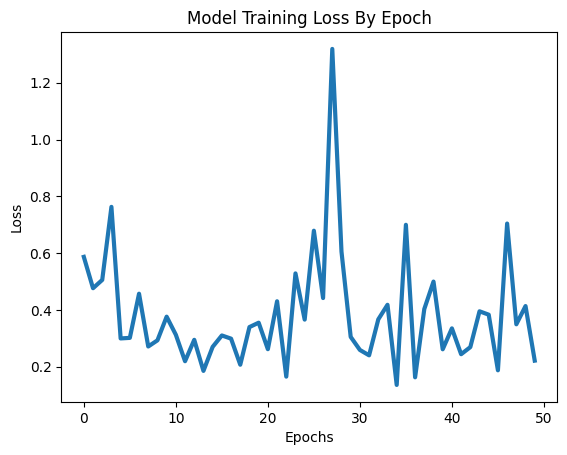

In [61]:
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('Model Training Loss By Epoch')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

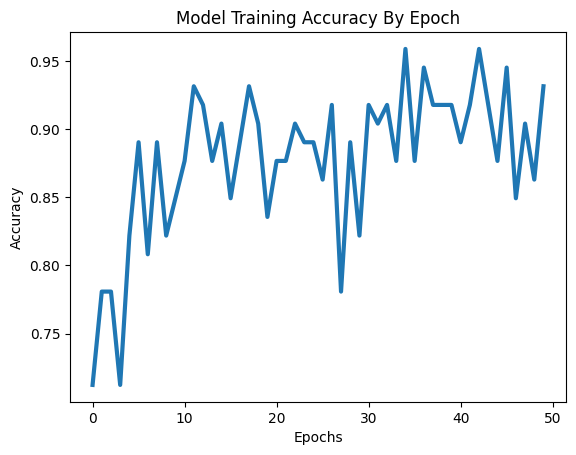

In [62]:
plt.plot(history.history['val_accuracy'], linewidth=3)
plt.title('Model Training Accuracy By Epoch')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [63]:
predictions = network.predict(test_dataset)
predictions = np.argmax(predictions, axis = 1)
predictions

73/73 [==============================] - 0s 3ms/step


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [64]:
accuracy_score(test_dataset.classes, predictions)

0.9315068493150684

<Axes: >

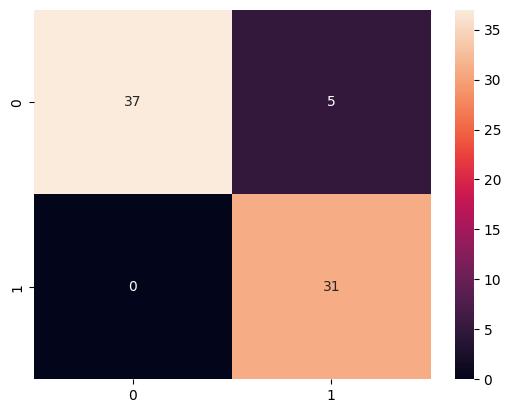

In [65]:
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [66]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        42
           1       0.86      1.00      0.93        31

    accuracy                           0.93        73
   macro avg       0.93      0.94      0.93        73
weighted avg       0.94      0.93      0.93        73



## Saving and loading the model

In [69]:
#create_empty_directory(model_directory)
model_json = network.to_json()
with open(f'{model_directory}/network.json','w') as json_file:
  json_file.write(model_json)

In [70]:
network_saved = save_model(network, f'{model_directory}/weights.hdf5')

<ipython-input-70-607e19d7058f>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, f'{model_directory}/weights.hdf5')


In [71]:
with open(f'{model_directory}/network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_6_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_6", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 64, 64, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null

In [72]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights(f'{model_directory}/weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [73]:
network_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 32)         

### Classifying one single image

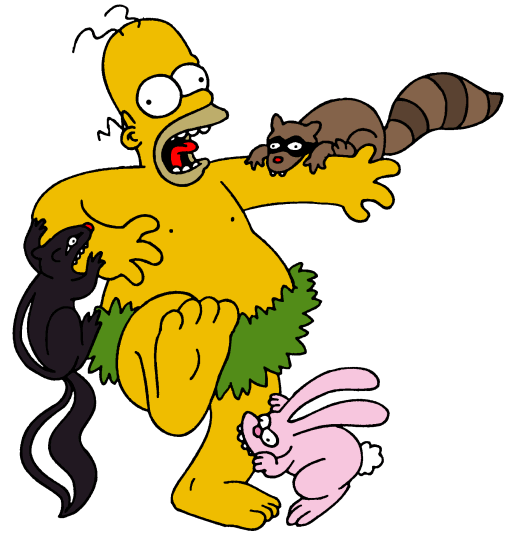

In [74]:
image = cv2.imread(f'{test_set_path}/homer/homer15.bmp')
cv2_imshow(image)

In [75]:
image = cv2.resize(image, (64, 64))
image = image / 255
image = image.reshape(-1, 64, 64, 3)
image.shape

(1, 64, 64, 3)

In [76]:
result = network_loaded(image)
result = np.argmax(result)
result

1

In [77]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Homer
